In [ ]:
#basic stuff :
!pip install langchain langchain-openai langchain-community openai python-dotenv


INFO: pip is looking at multiple versions of langchain-openai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of langchain-community to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32

##CONDITIONAL GRAPHS:

In [ ]:
!pip install langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.2/471.2 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.3/208.3 kB 23.7 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.79
    Uninstalling langchain-core-0.3.79:
      Successfully uninstalled langchain-core-0.3.79
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-openai 0.3.35 requires langchain-core<1.0.0,>=0.3.78, but you have langchain-core 1.0.4 which is incompatible.
langchain 0.3.27 requires langchain-core<1.0.0,>=0.3.72, but you have langchain-core 1.0.4 which is incompatible.


In [ ]:
from langgraph.graph import StateGraph, END

state = {"age" : 20, "is_unc": True}
def start(state):
    age = state.get("age", 0)
    state["is_unc"] = age >= 20
    print(f"start: age={age}, is_unc={state['is_unc']}")
    return state
#state = {"age" : 20, "is_unc": True, "msg" : "wtv message"}
def kid(state):
    state["msg"] = f"You're {state['age']} — a kid"
    return state

def unc(state):
    state["msg"] = f"You're {state['age']} — an unc!"
    return state

def route(state):  # decide which branch to take
    return "unc" if state["is_unc"] else "kid"

graph = StateGraph(dict)
graph.add_node("start", start)
graph.add_node("kid", kid)
graph.add_node("unc", unc)


graph.set_entry_point("start")
graph.add_conditional_edges("start", route)
graph.add_edge("kid", END)
graph.add_edge("unc", END)

app = graph.compile()
print(app.invoke({"age": 15}))
print(app.invoke({"age": 22}))


start: age=15, is_unc=False
{'age': 15, 'is_unc': False, 'msg': "You're 15 — a kid"}
start: age=22, is_unc=True
{'age': 22, 'is_unc': True, 'msg': "You're 22 — an unc!"}


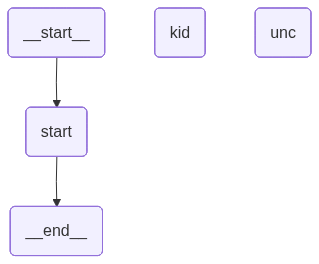

In [ ]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
import os
from dotenv import load_dotenv
from google.colab import userdata
from langchain.chat_models import ChatOpenAI


load_dotenv()
NEBIUS_KEY = userdata.get("NEBIUS_API_KEY")
OPENAI_KEY = userdata.get("OPENAI_API_KEY")
NEBIUS_BASE = "https://api.studio.nebius.com/v1"

llm = ChatOpenAI(
    model="meta-llama/Meta-Llama-3.1-8B-Instruct",
    temperature=0.6,
    max_tokens=512,
    openai_api_base=NEBIUS_BASE,
    openai_api_key=NEBIUS_KEY
)


/tmp/ipython-input-2800840027.py:12: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the `langchain-openai package and should be used instead. To use it run `pip install -U `langchain-openai` and import as `from `langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(


##Simplest agentic bot in langraph

In [ ]:
#from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage

# expecting : {input : "what is a human"}
def process(state):
  #user_msg = what is a human
    user_msg = state["input"]
    response = llm.invoke([HumanMessage(content=user_msg)])
    print(f"\nAI: {response.content}")
    return state

# create a small graph
graph = StateGraph(dict)
graph.add_node("process", process)

graph.add_edge(START, "process")
graph.add_edge("process", END)

# compile the agent
agent = graph.compile()

# run interactively
while True:
    user_input = input("You: ")
    if user_input.lower() == "exit":
        break
    agent.invoke({"input": user_input})


You: hello

AI: Hello! How can I assist you today?
You: i want water

AI: I think I can help you with that!

Here are a few options to get you a glass of water:

1. **Get up and get a glass yourself**: If you're in a physical location, you can get up and get a glass of water from the kitchen or a nearby water source.
2. **Ask someone to get you a glass of water**: If you're with someone, you can ask them to get you a glass of water.
3. **Use a water dispenser or a water fountain**: If you're in a public place or a building with a water dispenser or fountain, you can go there to get a drink of water.
4. **Order a glass of water from a server or bartender**: If you're in a restaurant or bar, you can order a glass of water from the server or bartender.

If you're not in a physical location, I can also offer you some virtual water in the form of a fun fact or a joke. Would you like that?
You: exit


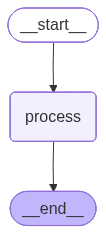

In [ ]:
from IPython.display import Image, display
display(Image(agent.get_graph().draw_mermaid_png()))

##A react agent:
1. Tools
2. integrating with LLMs

In [ ]:
pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=e1dda7d082d2b5f537f26c04912de652f8fbf62685ba0ebddc3b5e9c408b44e3
  Stored in directory: /root/.cache/pip/wheels/63/47/7c/a9688349aa74d228ce0a9023229c6c0ac52ca2a40fe87679b8
Successfully built wikipedia


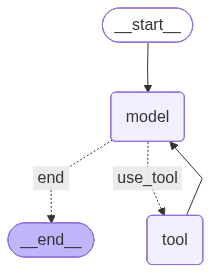

================================ Human Message =================================

What is the population of the capital city of India?
================================== Ai Message ==================================

According to Wikipedia, the population of New Delhi, the capital city of India, is approximately 29.2 million (2020 estimates). However, the population of the National Capital Territory of Delhi (NCT Delhi) is around 46 million (2020 estimates), which includes the urban agglomeration of New Delhi and the surrounding areas.


In [ ]:
from dotenv import load_dotenv
from IPython.display import Image, display

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, END

from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper


from langgraph.prebuilt import ToolNode

#can use load_tools as well
wiki_wrapper = WikipediaAPIWrapper(lang="en", top_k_results=2)
wikipedia_tool = WikipediaQueryRun(api_wrapper=wiki_wrapper)

TOOLS = [wikipedia_tool]


def model_call(state: dict) -> dict:
    """
    The LLM decides what to do or gives final answer.
    """
    system = SystemMessage(content="You are a factual assistant. Use Wikipedia to answer accurately.")
    messages = state.get("messages", [])
    response = llm.invoke([system] + messages)
    return {"messages": [response]}

def should_continue(state: dict):
    """
    If model wants to use a tool, go to tool node. Else end.
    """
    last = state["messages"][-1]
    if getattr(last, "tool_calls", None):
        return "use_tool"
    return "end"


graph = StateGraph(dict)

graph.add_node("model", model_call)

tool_node = ToolNode(tools=TOOLS)
graph.add_node("tool", tool_node)

graph.set_entry_point("model")

graph.add_conditional_edges(
    "model",
    should_continue,
    {
        "use_tool": "tool",
        "end": END,
    },
)

graph.add_edge("tool", "model")

app = graph.compile()

#optional - visual
display(Image(app.get_graph().draw_mermaid_png()))

def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        try:
            message.pretty_print()
        except Exception:
            print(message)

inputs = {"messages": [HumanMessage(content="What is the population of the capital city of India?")]}
print_stream(app.stream(inputs, stream_mode="values"))


##Multi-agent:

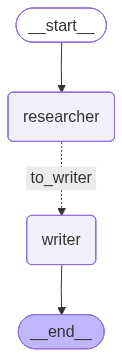

---- STREAM ITEM ----
Input: What is CAG in AI, summarize main resources
Research entries: 0


[Researcher LLM decision]: NO_WIKI
The question appears to be about a specific concept in AI, but lacks context and specific information, making it difficult to determine the relevant resources without more details.
---- STREAM ITEM ----
Input: What is CAG in AI, summarize main resources
Research entries: 1
  [1] decision: NO_WIKI
The question appears to be about a specific concept in AI, but lacks context and specific information, making it difficult to determine the relevant resources without more details.

---- STREAM ITEM ----
Input: What is CAG in AI, summarize main resources
Research entries: 1
  [1] decision: NO_WIKI
The question appears to be about a specific concept in AI, but lacks context and specific information, making it difficult to determine the relevant resources without more details.
Final answer:
 Based on the provided research notes, it appears that the question about CAG 

In [ ]:
from IPython.display import Image, display

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.utilities import WikipediaAPIWrapper
from langgraph.graph import StateGraph, START, END


wiki = WikipediaAPIWrapper(lang="en", top_k_results=3)

def researcher_node(state: dict) -> dict:
    user_q = state.get("input", "")
    # system prompt describes role and instructs return format (plain text)
    system = SystemMessage(content=(
        "You are ResearcherAgent. Decide whether the user's question needs factual evidence from Wikipedia. "
        "If yes, respond EXACTLY in this format:\n"
        "CALL_WIKI: <short_query>\n\n"
        "If not needed, respond EXACTLY with: NO_WIKI and then a brief observation sentence.\n\n"
        "Be concise and do not add extra text beyond the instruction format."
    ))

    prompt = HumanMessage(content=f"Question: {user_q}\nPrior research: {state.get('research', [])}\n\nDecide and respond.")
    resp = llm.invoke([system, prompt])
    decision_text = getattr(resp, "content", "").strip()
    print(f"\n[Researcher LLM decision]: {decision_text[:400]}")

    research = state.get("research", [])

    # If LLM requested a wiki call, parse and execute
    if decision_text.upper().startswith("CALL_WIKI:"):
        query = decision_text.split(":", 1)[1].strip()
        print(f"[Researcher] calling Wikipedia for query: {query}")
        try:
            wiki_output = wiki.run(query)
        except Exception as e:
            wiki_output = f"ERROR calling Wikipedia: {e}"
        # record both the decision and the tool output
        research.append({"decision": decision_text, "wiki_query": query, "wiki_output": wiki_output})
    else:
        # no wiki requested; store the observation text
        research.append({"decision": decision_text, "wiki_query": None, "wiki_output": None})

    return {"input": user_q, "research": research, "final": state.get("final")}

# writer agent
def writer_node(state: dict) -> dict:
    user_q = state.get("input", "")
    research = state.get("research", [])
    # Build readable research summary to feed writer LLM
    research_texts = []
    for i, item in enumerate(research, 1):
        d = item.get("decision", "")
        q = item.get("wiki_query")
        w = item.get("wiki_output")
        research_texts.append(f"[{i}] decision: {d}")
        if q:
            research_texts.append(f"    wiki_query: {q}")
        if w:
            # truncate wiki output for prompt length
            research_texts.append(f"    wiki_output (truncated): {str(w)[:800]}")
    system = SystemMessage(content=(
        "You are WriterAgent. Using the provided research notes, produce a concise final answer to the user's question. "
        "If there are Wikipedia findings, cite them inline as (Wikipedia). End with a one-sentence summary."
    ))
    prompt = HumanMessage(content=f"Question: {user_q}\n\nResearch notes:\n" + "\n".join(research_texts) + "\n\nWrite final answer:")
    resp = llm.invoke([system, prompt])
    final_answer = getattr(resp, "content", "")
    return {"input": user_q, "research": research, "final": final_answer}


graph = StateGraph(dict)
graph.add_node("researcher", researcher_node)
graph.add_node("writer", writer_node)

# entry -> researcher
graph.set_entry_point("researcher")

# decision routing: after researcher, always go to writer (single round trip)

def route_after_research(state: dict) -> str:
    # simple: always proceed to writer in this demo
    return "to_writer"

graph.add_conditional_edges("researcher", route_after_research, {"to_writer": "writer"})

# after writer finish
graph.add_edge("writer", END)

app = graph.compile()

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # not in notebook / display not available — ignore
    pass


def print_stream(stream):
    for s in stream:
        print("---- STREAM ITEM ----")
        print("Input:", s.get("input"))
        print("Research entries:", len(s.get("research", [])))
        for i, r in enumerate(s.get("research", []), 1):
            print(f"  [{i}] decision:", r.get("decision"))
            if r.get("wiki_query"):
                print(f"       wiki_query: {r.get('wiki_query')}")
            if r.get("wiki_output"):
                print(f"       wiki_output (truncated): {str(r.get('wiki_output'))[:300]}")
        if s.get("final"):
            print("Final answer:\n", s.get("final"))
        print()


q = "What is CAG in AI, summarize main resources"
inputs = {"input": q, "research": []}
print_stream(app.stream(inputs, stream_mode="values"))


In [ ]:
q = "What is CAG in AI, summarize main resources"
inputs = {"input": q, "research": []}

# Run the LangGraph
results = list(app.stream(inputs, stream_mode="values"))
final_state = results[-1]

print("Final Answer:\n", final_state["final"])

In [ ]:
# mini_multiagent_wiki.py
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.utilities import WikipediaAPIWrapper
from langgraph.graph import StateGraph, END

wiki = WikipediaAPIWrapper(lang="en", top_k_results=2)

# ---- Researcher Agent ----
def researcher(state):
    q = state["question"]
    sys = SystemMessage(content="You are a researcher. If the question needs Wikipedia, say 'CALL_WIKI: <topic>'. Else say 'NO_WIKI'.")
    msg = llm.invoke([sys, HumanMessage(content=q)]).content.strip()
    research = state.get("research", [])

    if msg.startswith("CALL_WIKI:"):
        topic = msg.split(":",1)[1].strip()
        research.append({"topic": topic, "info": wiki.run(topic)})
    else:
        research.append({"topic": None, "info": "No Wikipedia lookup needed."})
    return {"question": q, "research": research}

# ---- Writer Agent ----
def writer(state):
    q = state["question"]
    notes = "\n".join([f"{r['topic']}: {r['info'][:300]}" for r in state["research"] if r["topic"]])
    sys = SystemMessage(content="You are a writer. Use notes to answer clearly and cite (Wikipedia).")
    msg = llm.invoke([sys, HumanMessage(content=f"Q: {q}\nNotes:\n{notes}")]).content
    return {"final": msg}

# ---- LangGraph Flow ----
graph = StateGraph(dict)
graph.add_node("researcher", researcher)
graph.add_node("writer", writer)
graph.set_entry_point("researcher")
graph.add_edge("researcher", "writer")
graph.add_edge("writer", END)
app = graph.compile()


q = "What is quantum computing?"
inputs = {"question": q, "research": []}

for s in app.stream(inputs, stream_mode="values"):
    if "final" in s:
        print("\n✅ Final Answer:\n", s["final"])


✅ Final Answer:
 **Quantum Computing**

Quantum computing is a new and rapidly growing field of computing that uses the principles of quantum mechanics to perform calculations and operations on data (Wikipedia).

**Key Features:**

1. **Quantum bits (qubits):** Unlike classical computers that use bits (0s and 1s), quantum computers use qubits, which can exist in multiple states simultaneously (superposition).
2. **Quantum parallelism:** Quantum computers can perform many calculations simultaneously, thanks to the principles of superposition and entanglement.
3. **Quantum algorithms:** Quantum computers use specialized algorithms that take advantage of quantum parallelism and interference to solve problems more efficiently.

**How it Works:**

1. **Quantum gate operations:** Quantum computers use quantum gate operations, such as rotations and entanglement swaps, to manipulate qubits.
2. **Quantum circuit:** Quantum algorithms are implemented as quantum circuits, which are a series of q